<a href="https://colab.research.google.com/github/Bor7c/Homie/blob/main/notebooks/Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Импортирование необходимых библиотек

In [1]:
#!pip install torchsummary
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary
import pickle
from sklearn.metrics import classification_report
from PIL import Image
from tqdm.auto import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

## Определяем видеокарту GPU, чтобы на ней учить нейронную сеть

In [2]:
!nvidia-smi

Fri Dec 20 12:55:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Загрузка и распаковка набора данных CIFAR100

In [4]:
!wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
!tar -xvzf cifar-100-python.tar.gz

--2024-12-20 12:56:01--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘cifar-100-python.tar.gz’

cifar-100-python.ta 100%[===================>] 161.17M  35.9MB/s    in 4.8s    

2024-12-20 12:56:06 (33.4 MB/s) - ‘cifar-100-python.tar.gz’ saved [169001437/169001437]

cifar-100-python/
cifar-100-python/file.txt~
cifar-100-python/train
cifar-100-python/test
cifar-100-python/meta


## Чтение тренировочной и тестовой выборки

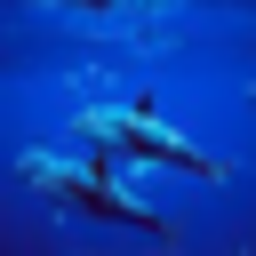

In [5]:
with open('cifar-100-python/train', 'rb') as f:
    data_train = pickle.load(f, encoding='latin1')
with open('cifar-100-python/test', 'rb') as f:
    data_test = pickle.load(f, encoding='latin1')

# Здесь указать ваши классы по варианту!!!
CLASSES = [1, 4, 15, 20, 30, 40, 50, 60, 70, 80]

train_X = data_train['data'].reshape(-1, 3, 32, 32)
train_X = np.transpose(train_X, [0, 2, 3, 1]) # NCWC -> NWHC
train_y = np.array(data_train['fine_labels'])
mask = np.isin(train_y, CLASSES)
train_X = train_X[mask].copy()
train_y = train_y[mask].copy()
train_y = np.unique(train_y, return_inverse=1)[1]
del data_train

test_X = data_test['data'].reshape(-1, 3, 32, 32)
test_X = np.transpose(test_X, [0, 2, 3, 1])
test_y = np.array(data_test['fine_labels'])
mask = np.isin(test_y, CLASSES)
test_X = test_X[mask].copy()
test_y = test_y[mask].copy()
test_y = np.unique(test_y, return_inverse=1)[1]
del data_test
Image.fromarray(train_X[50]).resize((256,256))

## Создание Pytorch DataLoader'a

In [34]:
batch_size = 512
dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(CLASSES))/1.
    dataset = TensorDataset(tensor_x, tensor_y) # создание объекта датасета
    dataloader[part] = DataLoader(dataset, batch_size=batch_size, shuffle=True) # создание экземпляра класса DataLoader
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fb628e0a8c0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fb62949d420>}

## Создание Pytorch модели сверточной нейронной сети

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean).to(device)
        self.std = torch.tensor(std).to(device)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return x.permute(0, 3, 1, 2)  # nhwc -> n

class GlobalMaxPool2d(nn.Module):
    def __init__(self):
        super(GlobalMaxPool2d, self).__init__()

    def forward(self, input):
        out = F.adaptive_max_pool2d(input, output_size=1)
        return out.flatten(start_dim=1)

class Cifar100_CNN(nn.Module):
    def __init__(self, hidden_size=32, classes=100):
        super(Cifar100_CNN, self).__init__()
        self.seq = nn.Sequential(
            Normalize([0.5074, 0.4867, 0.4411], [0.2011, 0.1987, 0.2025]),
            nn.Conv2d(3, hidden_size, 5, stride=4, padding=2),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Conv2d(hidden_size, hidden_size * 2, 3, stride=1, padding=1),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.AvgPool2d(4),
            nn.Dropout(0.5),
            nn.Flatten(),
            nn.Linear(hidden_size * 8, classes),
        )

    def forward(self, input):
        return self.seq(input)

HIDDEN_SIZE = 32
model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
model.to(device)
print(model(torch.rand(1, 32, 32, 3).to(device)))
summary(model, input_size=(32, 32, 3))


tensor([[ 0.3362, -0.1571, -0.2344,  0.1974,  0.2431, -0.0739, -0.1360, -0.3075,
          0.1422,  0.1535]], device='cuda:0', grad_fn=<AddmmBackward0>)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1            [-1, 3, 32, 32]               0
            Conv2d-2             [-1, 32, 8, 8]           2,432
           Dropout-3             [-1, 32, 8, 8]               0
              ReLU-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          18,496
           Dropout-6             [-1, 64, 8, 8]               0
              ReLU-7             [-1, 64, 8, 8]               0
         AvgPool2d-8             [-1, 64, 2, 2]               0
           Dropout-9             [-1, 64, 2, 2]               0
          Flatten-10                  [-1, 256]               0
           Linear-11                   [-1, 10]           2,570
Total params: 

## Выбор функции потерь и оптимизатора градиентного спуска

In [31]:
criterion = nn.CrossEntropyLoss()
# используется SGD c momentum
optimizer = optim.SGD(model.parameters(), lr=5e-4, momentum=0.9)

## Обучение модели по эпохам

  0%|          | 0/12000 [00:00<?, ?it/s]

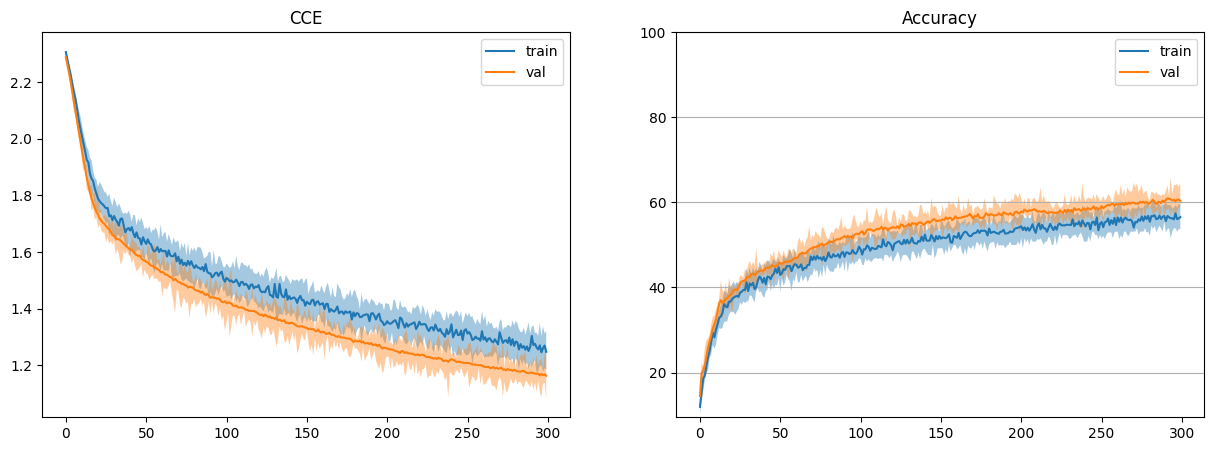

Обучение закончено за 67.11673092842102 секунд


In [32]:
EPOCHS = 500
REDRAW_EVERY = 20
steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])
# NEW
pbar = tqdm(total=EPOCHS*steps_per_epoch)
losses = []
losses_val = []
passed = 0
for epoch in range(EPOCHS):  # проход по набору данных несколько раз
    #running_loss = 0.0
    tmp = []
    model.train()
    for i, batch in enumerate(dataloader['train'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, labels = batch
        # на GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        # для подсчёта статистик
        #running_loss += loss.item()
        accuracy = (labels.detach().argmax(dim=-1)==outputs.detach().argmax(dim=-1)).\
                    to(torch.float32).mean().cpu()*100
        tmp.append((loss.item(), accuracy.item()))
        pbar.update(1)
    #print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / steps_per_epoch:.3f}')
    losses.append((np.mean(tmp, axis=0),
                   np.percentile(tmp, 25, axis=0),
                   np.percentile(tmp, 75, axis=0)))
    #running_loss = 0.0
    tmp = []
    model.eval()
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data
            # на GPU
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            #running_loss += loss.item()
            accuracy = (labels.argmax(dim=-1)==outputs.argmax(dim=-1)).\
                        to(torch.float32).mean().cpu()*100
            tmp.append((loss.item(), accuracy.item()))
    #print(f'[{epoch + 1}, {i + 1:5d}] val loss: {running_loss / steps_per_epoch_val:.3f}')
    losses_val.append((np.mean(tmp, axis=0),
                       np.percentile(tmp, 25, axis=0),
                       np.percentile(tmp, 75, axis=0)))
    if (epoch+1) % REDRAW_EVERY != 0:
        continue
    clear_output(wait=False)
    passed += pbar.format_dict['elapsed']
    pbar = tqdm(total=EPOCHS*steps_per_epoch, miniters=5)
    pbar.update((epoch+1)*steps_per_epoch)
    x_vals = np.arange(epoch+1)
    _, ax = plt.subplots(1, 2, figsize=(15, 5))
    stats = np.array(losses)
    stats_val = np.array(losses_val)
    ax[1].set_ylim(stats_val[:, 0, 1].min()-5, 100)
    ax[1].grid(axis='y')
    for i, title in enumerate(['CCE', 'Accuracy']):
        ax[i].plot(x_vals, stats[:, 0, i], label='train')
        ax[i].fill_between(x_vals, stats[:, 1, i],
                           stats[:, 2, i], alpha=0.4)
        ax[i].plot(x_vals, stats_val[:, 0, i], label='val')
        ax[i].fill_between(x_vals,
                           stats_val[:, 1, i],
                           stats_val[:, 2, i], alpha=0.4)
        ax[i].legend()
        ax[i].set_title(title)
    plt.show()
print('Обучение закончено за %s секунд' % passed)

## Проверка качества модели по классам на обучающей и тестовой выборках

In [33]:
for part in ['train', 'test']:
    y_pred = []
    y_true = []
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader[part], 0):
            inputs, labels = data
             # на GPU
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).detach().cpu().numpy()
            y_pred.append(outputs)
            y_true.append(labels.cpu().numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        print(part)
        print(classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),
                                    digits=4, target_names=list(map(str, CLASSES))))
        print('-'*50)

train
              precision    recall  f1-score   support

           1     0.6165    0.6720    0.6431       500
           4     0.4607    0.5280    0.4921       500
          15     0.5112    0.4120    0.4563       500
          20     0.6667    0.7520    0.7068       500
          30     0.6870    0.8560    0.7622       500
          40     0.5826    0.4020    0.4757       500
          50     0.3785    0.2680    0.3138       500
          60     0.8745    0.9060    0.8900       500
          70     0.8128    0.6860    0.7440       500
          80     0.4303    0.5620    0.4874       500

    accuracy                         0.6044      5000
   macro avg     0.6021    0.6044    0.5971      5000
weighted avg     0.6021    0.6044    0.5971      5000

--------------------------------------------------
test
              precision    recall  f1-score   support

           1     0.5620    0.6800    0.6154       100
           4     0.4444    0.5200    0.4793       100
          15    

# Часть 2. Сохранение модели в ONNX

In [ ]:
# сохраниение модели
# ПЕРВЫЙ СПОСОБ: сохранение параметров
PATH = 'cifar_cnn.pth'
torch.save(model.state_dict(), PATH)
# загрузка
new_model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
new_model.load_state_dict(torch.load(PATH))
new_model.eval()

# ВТОРОЙ СПОСОБ: сохранение всей архитектуры
PATH2 = 'cifar_cnn.pt'
torch.save(model, PATH2)
# загрузка
new_model_2 = torch.load(PATH2)
new_model_2.eval()

Cifar100_MLP(
  (seq): Sequential(
    (0): Normalize()
    (1): Conv2d(3, 32, kernel_size=(5, 5), stride=(4, 4), padding=(2, 2))
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=4, stride=4, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [ ]:
!pip install onnx

In [ ]:
# входной тензор для модели
x = torch.randn(1, 32, 32, 3, requires_grad=True).to(device)
torch_out = model(x)

# экспорт модели
torch.onnx.export(model,               # модель
                  x,                   # входной тензор (или кортеж нескольких тензоров)
                  "cifar100_CNN.onnx", # куда сохранить (либо путь к файлу либо fileObject)
                  export_params=True,  # сохраняет веса обученных параметров внутри файла модели
                  opset_version=9,     # версия ONNX
                  do_constant_folding=True,  # следует ли выполнять укорачивание констант для оптимизации
                  input_names = ['input'],   # имя входного слоя
                  output_names = ['output'],  # имя выходного слоя
                  dynamic_axes={'input' : {0 : 'batch_size'},    # динамичные оси, в данном случае только размер пакета
                                'output' : {0 : 'batch_size'}})

# Loss landscape

## идея https://arxiv.org/abs/1712.09913

In [ ]:
from copy import deepcopy
state_dict_backup = deepcopy(model.state_dict())

In [ ]:
def generate_theta(seed=None):
    model.eval()
    model.load_state_dict(state_dict_backup)
    if seed is not None:
        np.random.seed(seed)
    params = []
    with torch.no_grad():
        for w in model.parameters():
            params.append(w.detach().cpu().numpy())
    params_n = np.concatenate([p.flatten() for p in params]).size
    random_theta_flat = np.random.normal(size=params_n)
    random_theta = []
    offset = 0
    for p in params:
        p_weights = p.flatten().size
        random_theta.append(random_theta_flat[offset:offset+p_weights].\
                            reshape(*p.shape))
        # normalization
        rank = random_theta[-1].shape.__len__()
        if rank == 4: # convolution
            #print('Conv')
            # Frobenius norm
            norm_r = np.sqrt((random_theta[-1]**2).sum(axis=-1).sum(axis=-1))
            norm_p = np.sqrt((p**2).sum(axis=-1).sum(axis=-1))
            norm = (norm_p / norm_r).reshape(*norm_p.shape, 1, 1)
        elif rank == 2: # fully connected
            #print('FC')
            norm_r = np.sqrt((random_theta[-1]**2).sum(axis=-1))
            norm_p = np.sqrt((p**2).sum(axis=-1))
            norm = (norm_p / norm_r).reshape(-1, 1)
        elif rank == 1: # bias
            #print('bias')
            norm_r = np.sqrt((random_theta[-1]**2).sum())
            norm_p = np.sqrt((p**2).sum())
            norm = norm_p / norm_r
        random_theta[-1] = random_theta[-1]*norm
        offset += p_weights
    assert offset==params_n, \
            "Not all params are utilized. Expected %d, found %d"%(params_n, offset)
    return random_theta

theta1 = generate_theta(seed=0)
theta2 = generate_theta(seed=1011)

In [ ]:
criterion2 = nn.CrossEntropyLoss(reduction='none')
loss_curve = []
alphas = np.arange(-1500, 1500, step=5)/1000
for alpha in tqdm(alphas):
    state_dict = model.state_dict()
    for (k, v), v_new in zip(state_dict_backup.items(), theta1):
        tensor = v.clone().detach() + \
              alpha*(torch.tensor(v_new, device=device) - v.clone().detach())
        state_dict[k] = tensor
    model.load_state_dict(state_dict)
    loss = []

    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data
            # на GPU
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).detach()
            loss.append(criterion2(outputs, labels).detach().cpu().numpy())
    loss_curve.append(np.concatenate(loss).mean())

  0%|          | 0/600 [00:00<?, ?it/s]

Text(0, 0.5, 'CCE, log10')

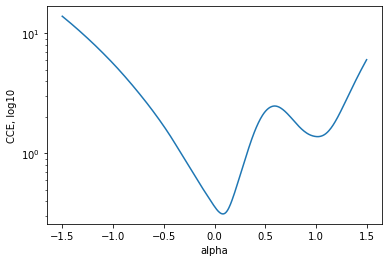

In [ ]:
plt.plot(alphas, loss_curve)
plt.yscale('log')
plt.xlabel('alpha')
plt.ylabel('CCE, log10')

## 2D

In [ ]:
# увеличив step, можно значительно ускорить вычисления
# однако вместе с этим теряется разрешение
alphas = []
vals = np.arange(-150, 151, step=5)/100
size = vals.size

# создаём заданный растр
for a1 in vals:
    for a2 in vals:
        alphas.append((a1, a2))

alphas = np.array(alphas)

In [ ]:
Z = []
for a1, a2 in tqdm(alphas):
    state_dict = model.state_dict()
    for (k, v), v_new, v_new2 in zip(state_dict_backup.items(), theta1, theta2):
        # линейная интерполяция
        tensor = v.clone().detach() + \
                 a1*(torch.tensor(v_new, device=device) - \
                     v.clone().detach())
        # ещё раз со вторым вектором
        tensor = tensor + a2*(torch.tensor(v_new2, device=device) - tensor)
        state_dict[k] = tensor
        #print(k, tensor, v_new)
    model.load_state_dict(state_dict)
    loss = []
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data
            # на GPU
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).detach()#.cpu().numpy()
            loss.append(criterion2(outputs, labels).detach().cpu().numpy())
    Z.append(np.concatenate(loss).mean())
ZZ = np.array(Z)

  0%|          | 0/3721 [00:00<?, ?it/s]

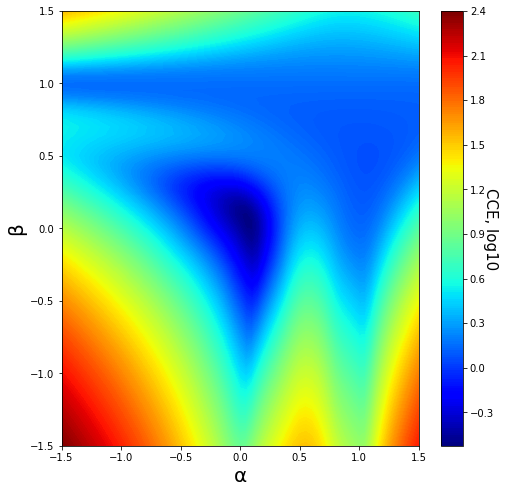

In [ ]:
# настройка размера графика
plt.figure(figsize=(8, 8))
# отрисовка закрашенных контуров, аналогично 2 части 1 ЛР
cs = plt.contourf(alphas[:,0].reshape(size, size),
             alphas[:,1].reshape(size, size),
             np.log10(ZZ.reshape(size, size)),
             levels=255,
             cmap=plt.cm.jet,
             )
# установка цветовой шкалы и её названия
plt.colorbar(cs).ax.set_ylabel('CCE, log10', rotation=270, fontsize=15)
# установка названий осям X, Y
plt.xlabel('α', fontsize=20)
plt.ylabel('β', fontsize=20)
plt.show()

## 3D

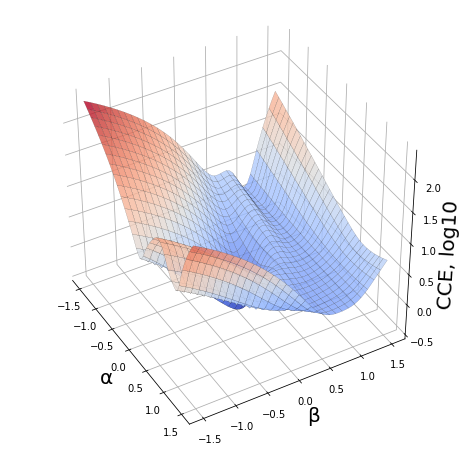

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": "3d"})
# установка названий осям X, Y и Z
ax.set_xlabel('α', fontsize=20)
ax.set_ylabel('β', fontsize=20)
ax.set_zlabel('CCE, log10', fontsize=20)
# выставление прозрачности сетки, для красоты
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# отрисовка 3D поверхности, данные для отрисовки аналогичны contourf
surf = ax.plot_surface(alphas[:,0].reshape(size, size),
                       alphas[:,1].reshape(size, size),
                       np.log10(ZZ.reshape(size, size)),
                       cmap=plt.cm.coolwarm,
                       linewidth=0.1,
                       edgecolors='k',
                       alpha=0.8,
                       antialiased=True)
# первый агрумент - вращение вокруг XY, второрй аргумент - вокруг YZ
ax.view_init(40, -30)